In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ssl
import geopandas as gpd
ssl._create_default_https_context = ssl._create_unverified_context
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import webbrowser
from pyogrio import read_dataframe

In [16]:
buurt = 'Oorden'
n_predictions = 3

In [17]:
# first create a map which can be used later in the analysis
file_path = '../data/buurt_2020_v3.shp'
buurten_map = read_dataframe(file_path)
clean_up = False
provincie_utrecht_gemeente =[
    'Amersfoort',
    'Baarn',
    'Bunnik',
    'Bunschoten',
    'De Bilt',
    'De Ronde Venen',
    'Eemnes',
    'Houten',
    'Leusden',
    'Lopik',
    'Montfoort',
    'Nieuwegein',
    'Oudewater',
    'Renswoude',
    'Rhenen',
    'Soest',
    'Stichtse Vecht',
    'Utrecht',
    'Utrechtse Heuvelrug',
    'Veenendaal',
    'Vijfheerenlanden',
    'Wijk bij Duurstede',
    'Woerden',
    'Woudenberg',
    'IJsselstein',
    'Zeist']

gemeente_selectie = provincie_utrecht_gemeente
gem_map = buurten_map.loc[buurten_map['GM_NAAM'].isin(gemeente_selectie)]

if clean_up:
    drop_buurten_houten = ['Buitengebied Houten West',
        'Buitengebied Houten Oost', "Dorp 't Goy", "'t Goyse Dorp",
        "Buitengebied 't Goy", "'t Waal", 'Tull',
        "Buitengebied Tull en 't Waal", 'Dorp Schalkwijk West',
        'Dorp Schalkwijk Oost', 'Buitengebied Schalkwijk West',
        'Buitengebied Schalkwijk Oost','Bruggen', 'Bogen', 'De Poel',
        'Schepen', 'Boten', 'Honen', 'Kaden', 'Vesten', 'De Staart',
        'Hof van Wulven', 'Rondweg Noord-Oost', 'Rondweg Noord-West',
        'Rondweg Zuid-Oost', 'Rondweg Zuid-West'] 

    drop_buurten_utrecht = [
        'Bedrijventerrein Lageweide',
        'Haarzuilens en omgeving',
        'Bedrijventerrein en omgeving',
        'Utrecht Science Park',
                'Bedrijvengebied Strijkviertel', 
                'Bedrijvengebied Papendorp',
                'Rijnenburg',
                'Poldergebied Overvecht' ,
                ]

    gem_map = gem_map.loc[~gem_map['BU_NAAM'].isin(drop_buurten_houten)]
    gem_map = gem_map.loc[~gem_map['BU_NAAM'].isin(drop_buurten_utrecht)]


#### Ophalen van dataset

In [18]:
buurten = pd.read_csv('../data/buurten.csv', index_col=0)

In [30]:
buurten.columns

Index(['buurt_code', 'gm_naam', 'regio', 'aantal_inwoners',
       'aantal_inwoners_tussen_25_44_percentage',
       'aantal_huishoudens_met_kinderen_percentage',
       'gemiddelde_huishoudensgrootte', 'woningvoorraad',
       'gemiddelde_woningwaarde', 'meergezinswoning_percentage',
       'bewoond_percentage', 'koopwoning_percentage',
       'bouwjaar_vanaf_2000_percentage', 'afstand_tot_ziekenhuis_km',
       'afstand_tot_grote_supermarkt_km', 'afstand_tot_cafe_km',
       'afstand_tot_kinderdagverblijf_km',
       'afstand_tot_buitenschoolseopvang_km', 'afstand_tot_openbaar_groen_km',
       'afstand_tot_park_of_plantsoen_km', 'afstand_tot_bos_km',
       'afstand_tot_hoofdverkeersweg_km', 'afstand_tot_treinstation_km',
       'AfstandTotSemiOpenbaarGroenTotaal_83', 'leefbarometer_score',
       'leefbarometer_fysieke_omgeving', 'leefbarometer_fysieke_overlast',
       'leefbarometer_sociale_samenhang', 'leefbarometer_voorzieningen',
       'aardgasverbruik_m3_gemiddeld', 'elektri

In [19]:
#remove nan's in dataset
buurten = buurten.dropna()  #for now we just drop them

#create x and identifier 
identifier = pd.DataFrame(buurten[['buurt_code', 'gm_naam', 'regio']])
X = buurten[buurten.columns[~buurten.columns.isin(identifier.columns)]]


In [20]:
X.head()

,aantal_inwoners,aantal_inwoners_tussen_25_44_percentage,aantal_huishoudens_met_kinderen_percentage,gemiddelde_huishoudensgrootte,woningvoorraad,gemiddelde_woningwaarde,meergezinswoning_percentage,bewoond_percentage,koopwoning_percentage,bouwjaar_vanaf_2000_percentage,...,leefbarometer_score,leefbarometer_fysieke_omgeving,leefbarometer_fysieke_overlast,leefbarometer_sociale_samenhang,leefbarometer_voorzieningen,aardgasverbruik_m3_gemiddeld,elektriciteitsverbruik_kwh_gemiddeld,social_economische_score_gemiddeld,geluid_van_treinverkeer,geluid_van_weg
0,710,36.62,5.63,1.4,396,335.0,69.0,91.0,26.0,2.0,...,4.22,0.02,-0.14,-0.04,0.24,1310.0,2430.0,-0.12,20.00,31.65
1,460,32.61,8.70,1.6,259,420.0,61.0,93.0,41.0,11.0,...,4.26,0.02,-0.10,-0.03,0.24,1280.0,2600.0,0.09,20.00,27.01
2,165,24.24,12.12,1.7,100,440.0,72.0,89.0,45.0,0.0,...,4.28,0.04,-0.11,-0.03,0.24,1350.0,2770.0,0.00,20.00,24.79
3,465,32.26,8.60,1.6,298,341.0,77.0,94.0,33.0,1.0,...,4.18,0.02,-0.18,-0.05,0.26,1170.0,2290.0,-0.04,20.00,30.61
4,1255,33.86,8.76,1.6,772,308.0,48.0,95.0,29.0,5.0,...,4.22,0.01,-0.09,-0.04,0.22,1150.0,2300.0,-0.12,20.45,28.56


#### Create similarity score and generate recommendations

In [21]:
# create similarities between features in the dataframe
cosine_sim_matrix = cosine_similarity(X, X) #normalized dot product

In [22]:
# buurt id
buurt_id = buurten[['buurt_code', 'regio']]

# zet naam om naar id van de buurt
code_van_buurt = buurt_id.loc[buurt_id['regio'] == buurt, 'buurt_code'].item()

# get all buurt-codes in de dataset en de indices die daarbij horen
buurten_code = buurten['buurt_code']
indice_per_buurtcode = pd.Series(buurten.index, index=buurten['buurt_code']) 

In [23]:
# create dataframe with predictions
indice_voor_selected_buurtcode = indice_per_buurtcode[code_van_buurt]

# get score voor sim_score
sim_scores_per_andere_buurt = list(enumerate(cosine_sim_matrix[indice_voor_selected_buurtcode]))
sim_scores_per_andere_buurt = sorted(sim_scores_per_andere_buurt, key=lambda x: x[1], reverse=True)
sim_scores_top_n = sim_scores_per_andere_buurt[1:n_predictions+1]  # without own similarity

In [24]:
# get scores as seperate list
scores = [i[1] for i in sim_scores_top_n]
scores = [round(score, 4) for score in scores]

# get names of the buurten that are recommended
buurten_indices = [i[0] for i in sim_scores_top_n]
recommendations = buurten.iloc[buurten_indices]['buurt_code'].to_list()
recommendations_df = pd.DataFrame(list(zip(recommendations, scores)))
recommendations_naam = buurt_id.loc[buurt_id['buurt_code'].isin(recommendations), 'regio'].to_list()

In [25]:
recommendations_naam

['Akkerhoeve', 'Benschop Boveneind-Benedeneind', 'Donderberg']

De volgende buurten zijn aan te raden: ['Akkerhoeve', 'Benschop Boveneind-Benedeneind', 'Donderberg']


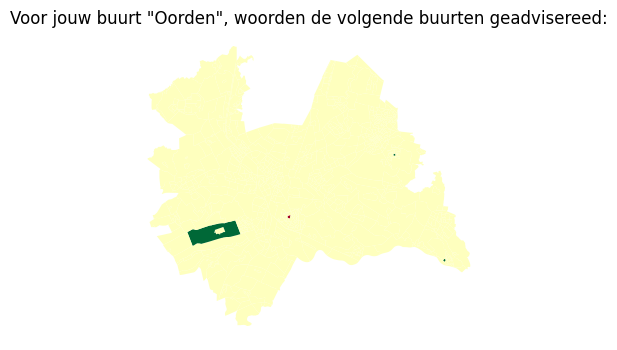

In [26]:
# create plot with predictions
merged_df = gem_map.merge(recommendations_df, left_on='BU_CODE', right_on=0, how='left')
merged_df.loc[~merged_df[1].isnull(),'dummy'] = 1           # green
merged_df.loc[merged_df[1].isnull(),'dummy'] = 0.5          # yellow
merged_df.loc[merged_df['BU_NAAM'] == buurt, 'dummy'] = 0   # red

# Maak een thematische kaart
p = merged_df.plot(column="dummy",
                    figsize = (6,4),
                    cmap='RdYlGn')
p.axis('off')
p.set_title(f'Voor jouw buurt "{buurt}", woorden de volgende buurten geadvisereed:')
print('De volgende buurten zijn aan te raden:', recommendations_naam)

In [27]:
### RENAME COLUMNS TO READABLE FORMAT
features_visualisatie = [ 'geometry', 'regio',
'buurt_code', 
'aantal_inwoners', 
'aantal_inwoners_tussen_25_44_percentage', 
'gemiddelde_huishoudensgrootte',
'woningvoorraad', 
'gemiddelde_woningwaarde', 
'meergezinswoning_percentage', 
'bewoond_percentage',
'koopwoning_percentage', 
'bouwjaar_vanaf_2000_percentage', 
'afstand_tot_grote_supermarkt_km', 
'afstand_tot_park_of_plantsoen_km', 
'afstand_tot_hoofdverkeersweg_km',
'afstand_tot_treinstation_km',
'leefbarometer_score', 
'aardgasverbruik_m3_gemiddeld', 
'elektriciteitsverbruik_kwh_gemiddeld',
'social_economische_score_gemiddeld', 
'geluid_van_treinverkeer',
'geluid_van_weg'
]

In [28]:
geometry = gem_map[['geometry', 'BU_CODE']]
geometry = geometry.merge(buurt_id, left_on='BU_CODE', right_on='buurt_code')
explore = geometry.merge(buurten, left_on='BU_CODE', right_on='buurt_code', how='left')
recommendations_plus_buurt = recommendations 
recommendations_plus_buurt.append(code_van_buurt)

explore = explore.loc[explore['BU_CODE'].isin(recommendations_plus_buurt)]
explore = explore[explore.columns[explore.columns.isin(features_visualisatie)]]

In [29]:
import os
explore_interaction = explore.explore(popup=True)

# and then we write the map to disk
explore_interaction.save('recommendations_map.html')

# then open it
webbrowser.open('file://' + os.path.realpath('recommendations_map.html'))

True